In [1]:
import sys
import os
import time
import glob
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
print('python version', sys.version_info)
print('tf version', tf.__version__, 'keras version', keras.__version__)

python version sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
tf version 2.2.0 keras version 2.3.0-tf


In [3]:
current_time_millis = lambda: int(round(time.time() * 1000))

# Data Preparation


### Datasource folders


In [4]:
YAHOO_DS="../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0"
DIRS_FILE_EXTENSIONS = {'A1Benchmark' : "*.csv", \
                        'A2Benchmark' : "*.csv", \
                        'A3Benchmark' : "*TS*.csv", \
                        'A4Benchmark' : "*TS*.csv" }

print("benchmark folders and file extensions")
for DIR, extension in DIRS_FILE_EXTENSIONS.items():
    Benchmark_dir  = YAHOO_DS + os.path.sep + DIR + os.path.sep 
    print("{} .. file extensions {}".format(Benchmark_dir, extension))

benchmark folders and file extensions
../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/ .. file extensions *.csv
../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/ .. file extensions *.csv
../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/ .. file extensions *TS*.csv
../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/ .. file extensions *TS*.csv


### Read data 

In [5]:
def read_data_with_labels(file, timeVariantColumns, labelColumnNum):
    df = pd.read_csv(file)
    data = df.values.astype('float64')
    tsData = df[timeVariantColumns].values.astype('float64')
    labels = data[:, labelColumnNum].reshape((-1,1))
    tsDataWithLabels = np.hstack((tsData, labels))
    return tsDataWithLabels, data

### Prepare look back window based data set

In [6]:
def look_back_and_create_dataset(tsDataWithLabels, look_back = 1):
    lookbackTsDataX = [] 
    lookbackTsDataYAndLabel = []
    for i in range(look_back, len(tsDataWithLabels)):
        a = tsDataWithLabels[i-look_back:i, 0]
        lookbackTsDataX.append(a)
        lookbackTsDataYAndLabel.append(tsDataWithLabels[i])
    return np.hstack((np.array(lookbackTsDataX), np.array(lookbackTsDataYAndLabel)))

### Prepare train and test splits

In [7]:
def split_data_set(dataset, split=0.67):
    train_size = int(len(dataset) * split)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    return train, test

In [8]:
def get_train_test(file_name, timeVariantColumns, labelColumnNum, split=.8, look_back=1):    
    tsDataWithLabels, data = read_data_with_labels(file_name, timeVariantColumns, labelColumnNum)    
    lookBackTsData = look_back_and_create_dataset(tsDataWithLabels, look_back) 
    lookBackTsDataTrain, lookBackTsDataTest = split_data_set(lookBackTsData, split)
    Xtrain, Xtest = lookBackTsDataTrain[:, :look_back], lookBackTsDataTest[:, :look_back]
    Ytrain, Ytest = lookBackTsDataTrain[:, look_back].reshape((-1,1)), lookBackTsDataTest[:, look_back].reshape((-1,1))                                                              
    return data, lookBackTsData, Xtrain, Ytrain, Xtest, Ytest  

# Train model

In [9]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(0,1))
    # fit normalization scaler to train only, but transform both train and test using the scaler fit to train
    scaler.fit(train)
    return scaler, scaler.transform(train), scaler.transform(test)

In [10]:
def train(Xtrain, Ytrain, batch_size=32, verbose = 0 ):
    model = Sequential()
    model.add(Dense(8, input_shape=Xtrain.shape[1:], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')    
    model.fit(Xtrain, Ytrain, epochs=25, batch_size=batch_size, verbose=verbose)
    return model

In [11]:
def predict(model, X):
    return model.predict(X)

In [12]:
def evaluate_model(model, X, Y):
    score = model.evaluate(X, Y, verbose=1)
    return score, sqrt(score)

In [13]:
def plot_actuals_vs_predictions(Y, YtrainPredicted, YtestPredicted, look_back):
    trainPredictPlot = np.empty_like(Y)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[:len(YtrainPredicted), :] = YtrainPredicted
    
    testPredictPlot = np.empty_like(Y)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(YtrainPredicted):len(Y), :] = YtestPredicted    

    #Now Plot
    plt.figure(figsize=(40,10))
    plt.plot(testPredictPlot, label ='Test Prediction')
    plt.plot(trainPredictPlot, label ='Train Prediction')
    plt.plot(Y, label = 'Actual')
    plt.legend(("Test Prediction", "Train Prediction", "Actual"), loc=3)
    plt.show()

In [14]:
def get_deviations(model, X, Y):
    scalerX = MinMaxScaler(feature_range=(0,1))
    scalerY = MinMaxScaler(feature_range=(0,1))    
    deviations = np.absolute(scalerY.fit_transform(Y) - model.predict(scalerX.fit_transform(X)))
    print("Deviation Min {}, Max {}".format(np.amin(deviations, axis=0), np.amax(deviations, axis=0)))    
    return deviations

In [15]:
def get_records_above_deviation_threshold(model, X, Y, threshold=0.1):
    deviations = get_deviations(model, X, Y)
    labels = (deviations > threshold).astype('int')
    print("Deviation > {} is_anomaly labels in data {}".format(threshold, np.unique(labelsThreshold, return_counts = True)))
    return labels

In [16]:
def get_records_above_deviation_pctile(model, X, Y, pctile=95):
    deviations = get_deviations(model, X, Y)
    pctileDeviationValue = np.percentile(deviations, q=pctile, axis=0)
    print("Deviation {}th pctile {}".format(pctile, pctileDeviationValue ))
    labels = (deviations > pctileDeviationValue).astype('int')
    print("Deviation > {}th pctile is_anomaly labels in data {}".format(pctile, np.unique(labels, return_counts = True)))
    return labels

In [17]:
def get_classification_metrics(actual, predicted):
    return confusion_matrix(actual, predicted), precision_score(actual, predicted), recall_score(actual, predicted), f1_score(actual, predicted)

## Model search

In [18]:
def get_train_validation(Xtrain, Ytrain, validation_ratio=0.1):
    validation_size = int(len(Xtrain) * validation_ratio)
    Xtrain, Xvalid = Xtrain[validation_size:], Xtrain[:validation_size]
    Ytrain, Yvalid = Ytrain[validation_size:], Ytrain[:validation_size]
    return Xtrain, Ytrain, Xvalid, Yvalid

### KerasRegressor model wrapper

In [19]:
def baseline_model(input_shape):
    def build_model(input_shape=input_shape, n_hidden = 1, n_units = 96, learning_rate = 0.001):
        model = keras.models.Sequential()
        model.add(keras.layers.InputLayer(input_shape=input_shape))
        for layer in range(n_hidden):
            model.add(keras.layers.Dense(n_units, activation="relu"))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.Adam(lr=learning_rate)
        model.compile(loss="mse", optimizer=optimizer)
        return model
    return build_model

### Randomized search with KerasRegressor

#### The `perform_training_on_benchmark_directory` is a wrapper fucntion which calls data_read, look_back, split methords  

Decription for each parameters

    benchmark_dir             - The full path to a folder where the data resides. This will be the path to a A* Benchmark folders.
    extension_pattern         - File name extension pattern for files of this folder.
    timeVariantColumns        – The time variant column specifies a list of values that changes in time.  In case of Yahoo! It’s the “value” column.
    labelColumnNum            – Specifies the column number which denotes if that record is anomaly or not.  The case of A1Benchmark and A2Benchmark folder the field is marked as “is_anomaly” whereas in case of A3Benchmark and A4Benchmark its “anomaly”
    param_distribs             - Distribution of parameters to search for best model using randomized search.
    files_to_process  - Specifies the number of files that needs to be processed per directory.  
    plot_graph                          – Specifies to plot graph or not for each file.    
    validation_ratio    - What fraction of Xtrain, Ytrain to be used for early stopping validation.
    early_stop_patience - Stop optimizing after how many successive epochs without further loss reduction
    epochs              - Total number of epochs to try and optimize loss.
    batch_size          - Size of batches in each epoch
    n_iter              - 

In [24]:
# Do it on each benchmark directory files  
def perform_training_on_benchmark_directory(benchmark_dir, extension, timeVariantColumns, 
                                            labelColumnNum, param_distribs, files_to_process = 'ALL', plot_graph = 1,
                                            validation_ratio = 0.1, early_stop_patience = 5, epochs = 25, batch_size = 32,
                                            n_iter = 1, cv = 3, search_verbosity = 0, eval_verbosity = 0):
    pctile = 99.5
    split = 0.8
    look_back = 24

    if files_to_process == 'ALL' :
        num_files_to_process = len(benchmark_files)
    else :
        num_files_to_process = files_to_process
    
    Benchmark_dir  = YAHOO_DS + os.path.sep + benchmark_dir + os.path.sep 
    benchmark_files = glob.glob(Benchmark_dir + extension, recursive=True)

    resultsMap={} # results from this folder    
    for data_file in benchmark_files[:num_files_to_process]:
        print('File Name : ', data_file)
        # or use get_train_test_shuffled() ??
        data, lookBackTsData, Xtrain_full, Ytrain_full, Xtest, Ytest = get_train_test(data_file, timeVariantColumns,
                                                                                      labelColumnNum, split, look_back)
        print("Shapes: Xtrain_full {}, Ytrain_full {}, Xtest {}, Ytest {}".format(Xtrain_full.shape, Ytrain_full.shape, 
                                                                                  Xtest.shape, Ytest.shape))

        scalerX, scaledXtrain_full, scaledXtest = scale(Xtrain_full, Xtest)
        scalerY, scaledYtrain_full, scaledYtest = scale(Ytrain_full, Ytest)

        Xtrain, Ytrain, Xvalid, Yvalid = get_train_validation(scaledXtrain_full, scaledYtrain_full, validation_ratio=0.1)

        print("Shapes: Xtrain {}, Ytrain {}, Xvalid {}, Yvalid {}".format(Xtrain.shape, Ytrain.shape, 
                                                                          Xvalid.shape, Yvalid.shape))
        keras.backend.clear_session()

        regressor = keras.wrappers.scikit_learn.KerasRegressor(build_fn = baseline_model(input_shape=Xtrain.shape[1:]))

        early_stopping_cb = keras.callbacks.EarlyStopping(patience=early_stop_patience, restore_best_weights = True)

        rnd_search_cv = RandomizedSearchCV(regressor, param_distribs, n_iter = n_iter, cv = cv, verbose = search_verbosity)

        start_millis = current_time_millis()
        rnd_search_cv.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size, 
                                     validation_data=(Xvalid, Yvalid), 
                                     callbacks=[early_stopping_cb])

        end_millis = current_time_millis()

        model = rnd_search_cv.best_estimator_.model
        print("Best parameters {} best score {}:".format(rnd_search_cv.best_params_, -rnd_search_cv.best_score_))

        trainMSE = model.evaluate(scaledXtrain_full, scaledYtrain_full, verbose = eval_verbosity)
        print("Train Score: {0:.5f} MSE {1:.5f} RMSE".format(trainMSE, np.sqrt(trainMSE)))
        testMSE = model.evaluate(scaledXtest, scaledYtest, verbose = eval_verbosity)
        print("Test Score: {0:.5f} MSE {1:.5f} RMSE".format(testMSE, np.sqrt(testMSE)))
        
        reshapedX = lookBackTsData[:, :look_back]
        reshapedY = lookBackTsData[:, look_back].reshape((-1,1))
        
        # predict on whole data set and plot - this would require extra work for shuffled train/test split case
        if plot_graph == 1:
            YtrainPredicted = model.predict(scaledXtrain_full)
            YtestPredicted = model.predict(scaledXtest)
            plot_actuals_vs_predictions(reshapedY, 
                                        scalerY.inverse_transform(YtrainPredicted), scalerY.inverse_transform(YtestPredicted),
                                        look_back)

        # get deviations for whole dataset and id records with deviations > pctile threshold and asign an is_anomaly label
        predictedLabels = get_records_above_deviation_pctile(model, reshapedX, reshapedY, pctile)

        # actual is_anomaly labels in dataset
        actualLabels = (data[look_back:, labelColumnNum] != 0.0).astype('int')    
        print("Actual is_anomaly labels in data", np.unique(actualLabels, return_counts = True))

        # Compare calculated labels and actual labels to find confusion matrix, precision, recall, and F1
        conf_matrix, prec, recall, f1 = get_classification_metrics(actualLabels, predictedLabels)
        print("Confusion matrix \n{0}\nprecision {1:.5f}, recall {2:.5f}, f1 {3:.5f}".format(conf_matrix, prec, recall, f1))
        print("Time to train: {} ms".format(end_millis - start_millis))
        resultsMap[data_file] = {'traintime' : (end_millis - start_millis), 'model' : model, 
                                'best params' : rnd_search_cv.best_params_, 'best score' : -rnd_search_cv.best_score_,
                                'train MSE' : trainMSE, 'test MSE' : testMSE,
                                'precision' : prec, 'recall' : recall, 'f1' : f1, 'confusion_matrix' : conf_matrix}
         
        
    return resultsMap

In [25]:
def print_summary_for_benchmark_folder(resultsMap, benchmark_folder):
    precisions=[]
    recalls=[]
    f1s=[]
    times = []
    for v in resultsMap.values():
        precisions.append(v['precision'])
        recalls.append(v['recall'])
        f1s.append(v['f1'])
        times.append(v['traintime'])
    avg_prec = np.average(np.array(precisions))
    avg_recall = np.average(np.array(recalls))
    avg_f1 = np.average(np.array(f1s))
    avg_time = np.average(np.array(times))
    print(benchmark_folder, ": Avg precision {0:.5f} recall {1:.5f} f1 {2:.5f} time to train {3:.2f} ms".format(avg_prec, avg_recall, avg_f1, avg_time))   

## Loop through each folder and processes the number of files per configuration

Parameters are mainly the number of hidden layers and units per hidden layer. The number of units could be same for each hidden layer. It really doesn't matter much. **For now trying with the small param distributions - need to expand param space**. 
Also we need to increase epochs, n_iters perhaps.

In [26]:
param_distribs = {
    "n_hidden": np.arange(1, 5).tolist(), # upto 4 hidden layers
    "n_units": np.arange(24, 26).tolist() # 24-25 hidden layer units/neurons
}

File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_4.csv
Shapes: Xtrain_full (1119, 24), Ytrain_full (1119, 1), Xtest (280, 24), Ytest (280, 1)
Shapes: Xtrain (1008, 24), Ytrain (1008, 1), Xvalid (111, 24), Yvalid (111, 1)
Epoch 1/25
21/21 [==============================] - 0s 18ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 2/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 3/25
21/21 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 4/25
21/21 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 5/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 6/25
21/21 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 7/25
21/21 [==============================] - 0s 15ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 8/25
11/11 [==========

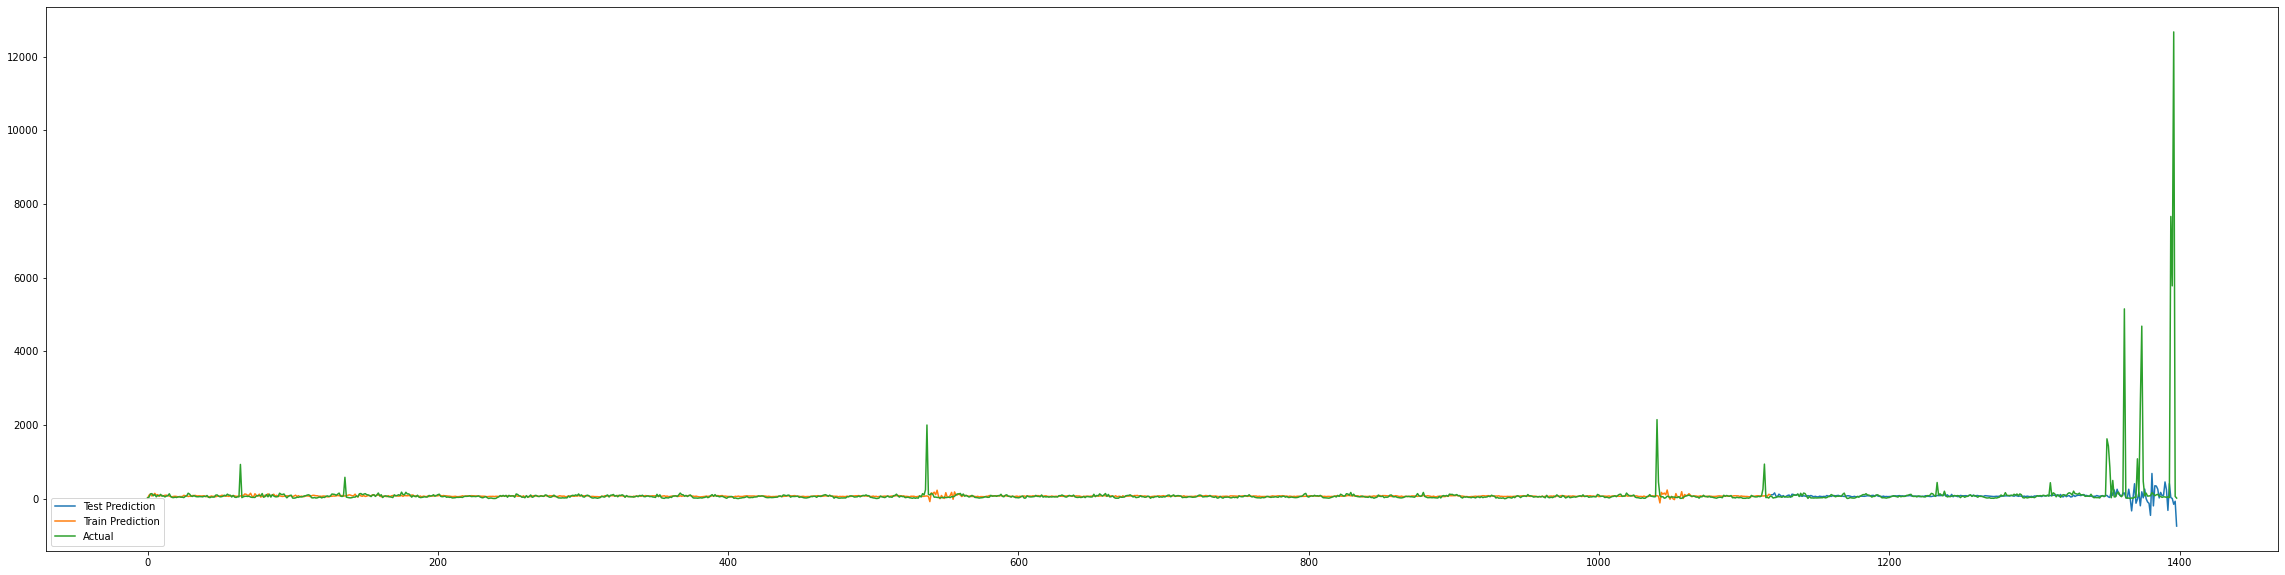

Deviation Min [0.00068734], Max [0.94281779]
Deviation 99.5th pctile [0.13731085]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1392,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1394,    5]))
Confusion matrix 
[[1392    2]
 [   0    5]]
precision 0.71429, recall 1.00000, f1 0.83333
Time to train: 9474 ms
File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_37.csv
Shapes: Xtrain_full (1128, 24), Ytrain_full (1128, 1), Xtest (282, 24), Ytest (282, 1)
Shapes: Xtrain (1016, 24), Ytrain (1016, 1), Xvalid (112, 24), Yvalid (112, 1)
Epoch 1/25
22/22 [==============================] - 0s 17ms/step - loss: 0.0838 - val_loss: 0.0410
Epoch 2/25
22/22 [==============================] - 0s 9ms/step - loss: 0.0422 - val_loss: 0.0309
Epoch 3/25
22/22 [==============================] - 0s 8ms/step - loss: 0.0295 - val_loss: 0.0240
Epoch 4/25
22/22 [==============================] - 0s 9ms/step -

32/32 [==============================] - 0s 5ms/step - loss: 0.0130 - val_loss: 0.0148
Epoch 12/25
32/32 [==============================] - 0s 5ms/step - loss: 0.0119 - val_loss: 0.0139
Epoch 13/25
32/32 [==============================] - 0s 5ms/step - loss: 0.0119 - val_loss: 0.0140
Epoch 14/25
32/32 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0142
Epoch 15/25
32/32 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0137
Epoch 16/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0137
Epoch 17/25
32/32 [==============================] - 0s 13ms/step - loss: 0.0113 - val_loss: 0.0137
Epoch 18/25
32/32 [==============================] - 0s 8ms/step - loss: 0.0112 - val_loss: 0.0140
Epoch 19/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0136
Epoch 20/25
32/32 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0142
Epoch 21/25
32/32 [==

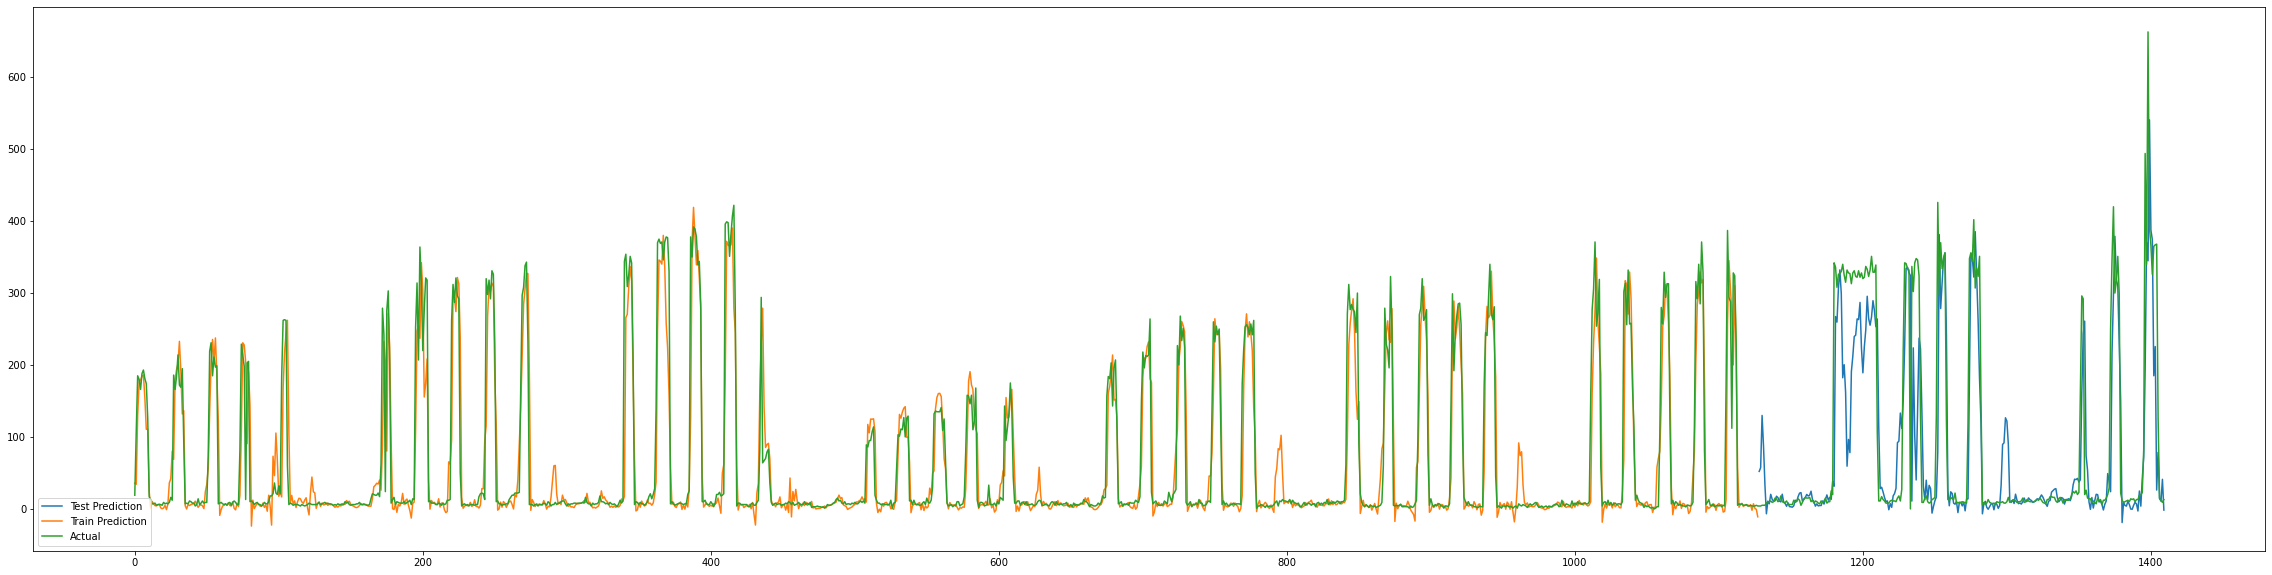

Deviation Min [7.28020616e-06], Max [0.5340974]
Deviation 99.5th pctile [0.4430964]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1402,    8]))
Actual is_anomaly labels in data (array([0, 1]), array([1376,   34]))
Confusion matrix 
[[1369    7]
 [  33    1]]
precision 0.12500, recall 0.02941, f1 0.04762
Time to train: 21690 ms
File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Shapes: Xtrain_full (1117, 24), Ytrain_full (1117, 1), Xtest (280, 24), Ytest (280, 1)
Shapes: Xtrain (1006, 24), Ytrain (1006, 1), Xvalid (111, 24), Yvalid (111, 1)
Epoch 1/25
21/21 [==============================] - 0s 18ms/step - loss: 0.0836 - val_loss: 0.0369
Epoch 2/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0114 - val_loss: 0.0027
Epoch 3/25
21/21 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 4/25
21/21 [==============================] - 0s 7m

Epoch 9/25
32/32 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 7.9361e-04
Epoch 10/25
32/32 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 6.7775e-04
Epoch 11/25
32/32 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 6.4206e-04
Epoch 12/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 6.5210e-04
Epoch 13/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 6.6207e-04
Best parameters {'n_units': 25, 'n_hidden': 2} best score 0.0013471132842823863:
Train Score: 0.00112 MSE 0.03346 RMSE
Test Score: 0.00078 MSE 0.02791 RMSE


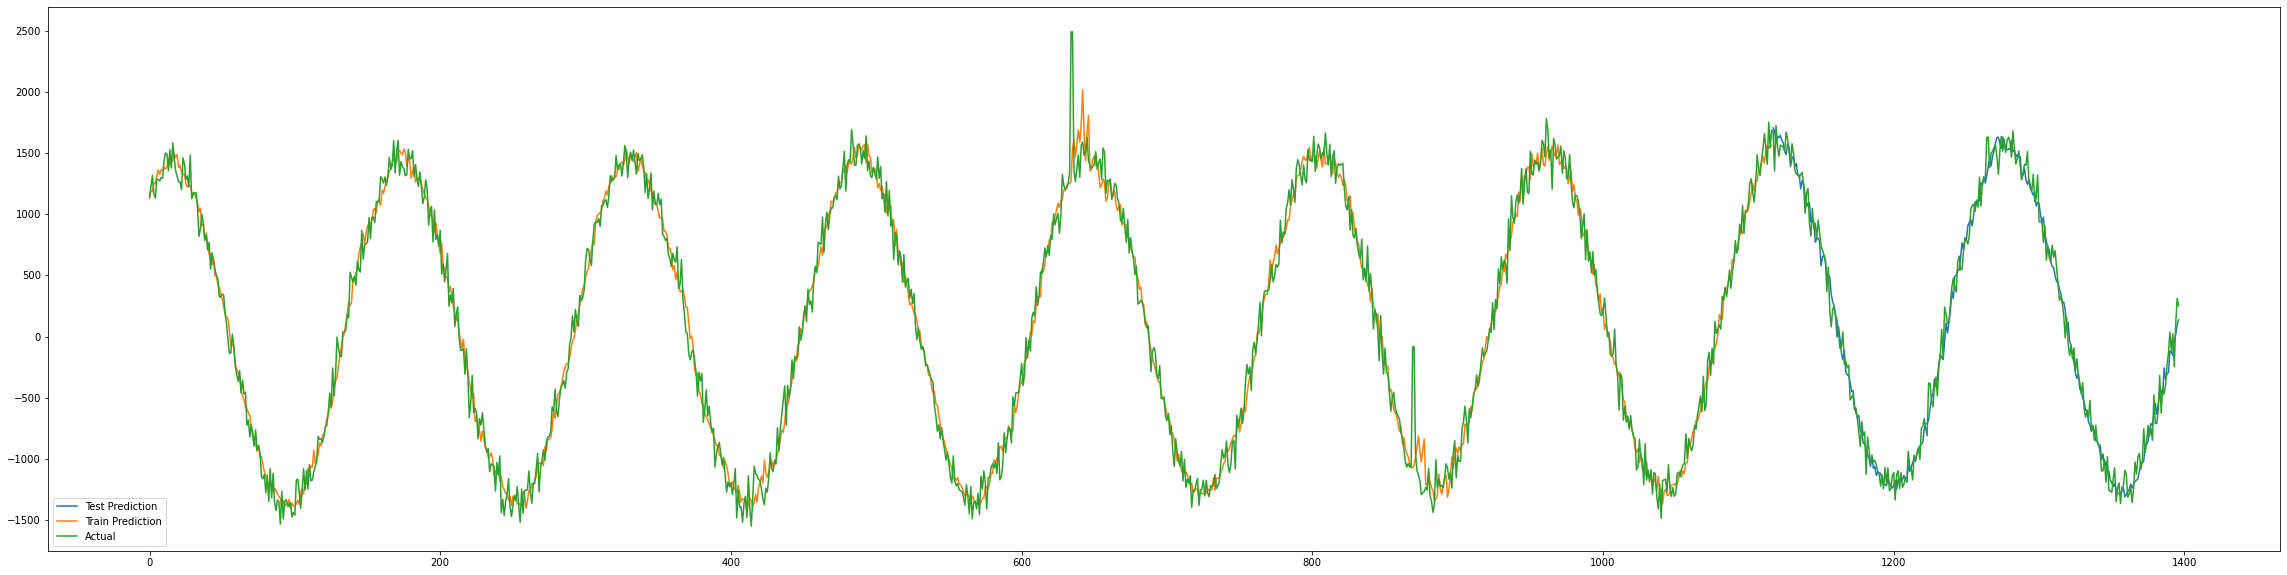

Deviation Min [4.56616458e-05], Max [0.30299395]
Deviation 99.5th pctile [0.09042649]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1390    3]
 [   0    4]]
precision 0.57143, recall 1.00000, f1 0.72727
Time to train: 16623 ms
File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_47.csv
Shapes: Xtrain_full (1117, 24), Ytrain_full (1117, 1), Xtest (280, 24), Ytest (280, 1)
Shapes: Xtrain (1006, 24), Ytrain (1006, 1), Xvalid (111, 24), Yvalid (111, 1)
Epoch 1/25
21/21 [==============================] - 0s 19ms/step - loss: 0.0087 - val_loss: 0.0025
Epoch 2/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0072 - val_loss: 0.0027
Epoch 3/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0068 - val_loss: 0.0020
Epoch 4/25
21/21 [==============================] - 0s 

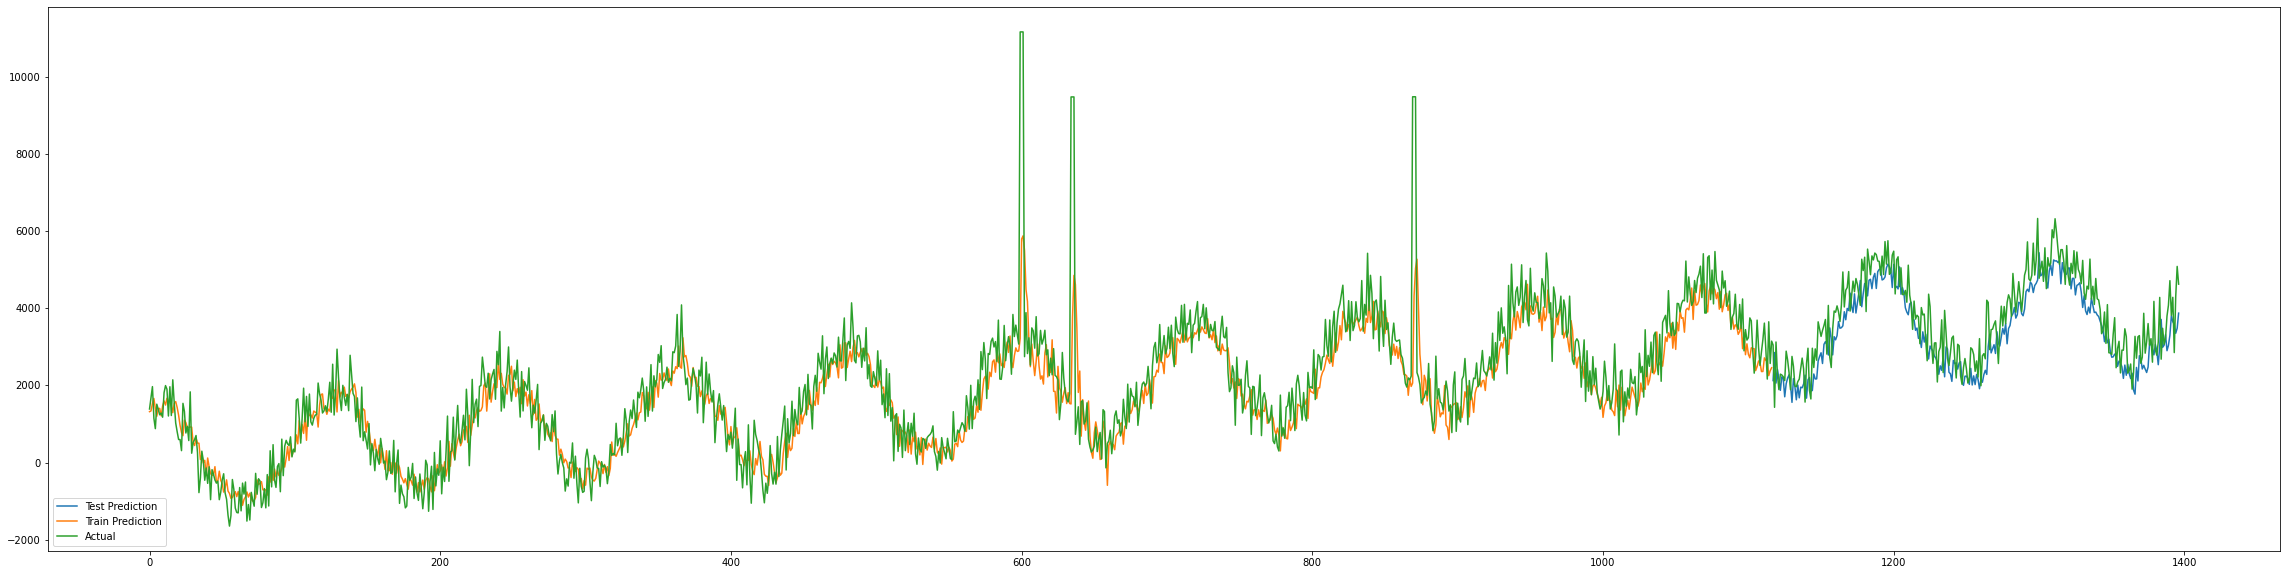

Deviation Min [1.69944411e-05], Max [0.62132154]
Deviation 99.5th pctile [0.36197131]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1390,    7]))
Actual is_anomaly labels in data (array([0, 1]), array([1388,    9]))
Confusion matrix 
[[1388    0]
 [   2    7]]
precision 1.00000, recall 0.77778, f1 0.87500
Time to train: 17509 ms
File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS8.csv
Shapes: Xtrain_full (1324, 24), Ytrain_full (1324, 1), Xtest (332, 24), Ytest (332, 1)
Shapes: Xtrain (1192, 24), Ytrain (1192, 1), Xvalid (132, 24), Yvalid (132, 1)
Epoch 1/25
25/25 [==============================] - 0s 17ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 2/25
25/25 [==============================] - 0s 5ms/step - loss: 8.6901e-04 - val_loss: 7.7331e-04
Epoch 3/25
25/25 [==============================] - 0s 7ms/step - loss: 6.0506e-04 - val_loss: 2.1589e-04
Epoch 4/25
25/25 [==================

38/38 [==============================] - 1s 13ms/step - loss: 3.9645e-04 - val_loss: 3.5238e-04
Epoch 10/25
38/38 [==============================] - 0s 8ms/step - loss: 4.3507e-04 - val_loss: 1.5298e-04
Epoch 11/25
38/38 [==============================] - 0s 8ms/step - loss: 3.7725e-04 - val_loss: 1.7294e-04
Epoch 12/25
38/38 [==============================] - 0s 6ms/step - loss: 3.7434e-04 - val_loss: 1.4560e-04
Epoch 13/25
38/38 [==============================] - 0s 6ms/step - loss: 3.7725e-04 - val_loss: 2.8026e-04
Epoch 14/25
38/38 [==============================] - 0s 5ms/step - loss: 3.7086e-04 - val_loss: 2.1469e-04
Epoch 15/25
38/38 [==============================] - 0s 7ms/step - loss: 3.5488e-04 - val_loss: 1.3065e-04
Epoch 16/25
38/38 [==============================] - 0s 8ms/step - loss: 3.7691e-04 - val_loss: 1.2940e-04
Epoch 17/25
38/38 [==============================] - 0s 6ms/step - loss: 3.9079e-04 - val_loss: 2.1458e-04
Epoch 18/25
38/38 [=============================

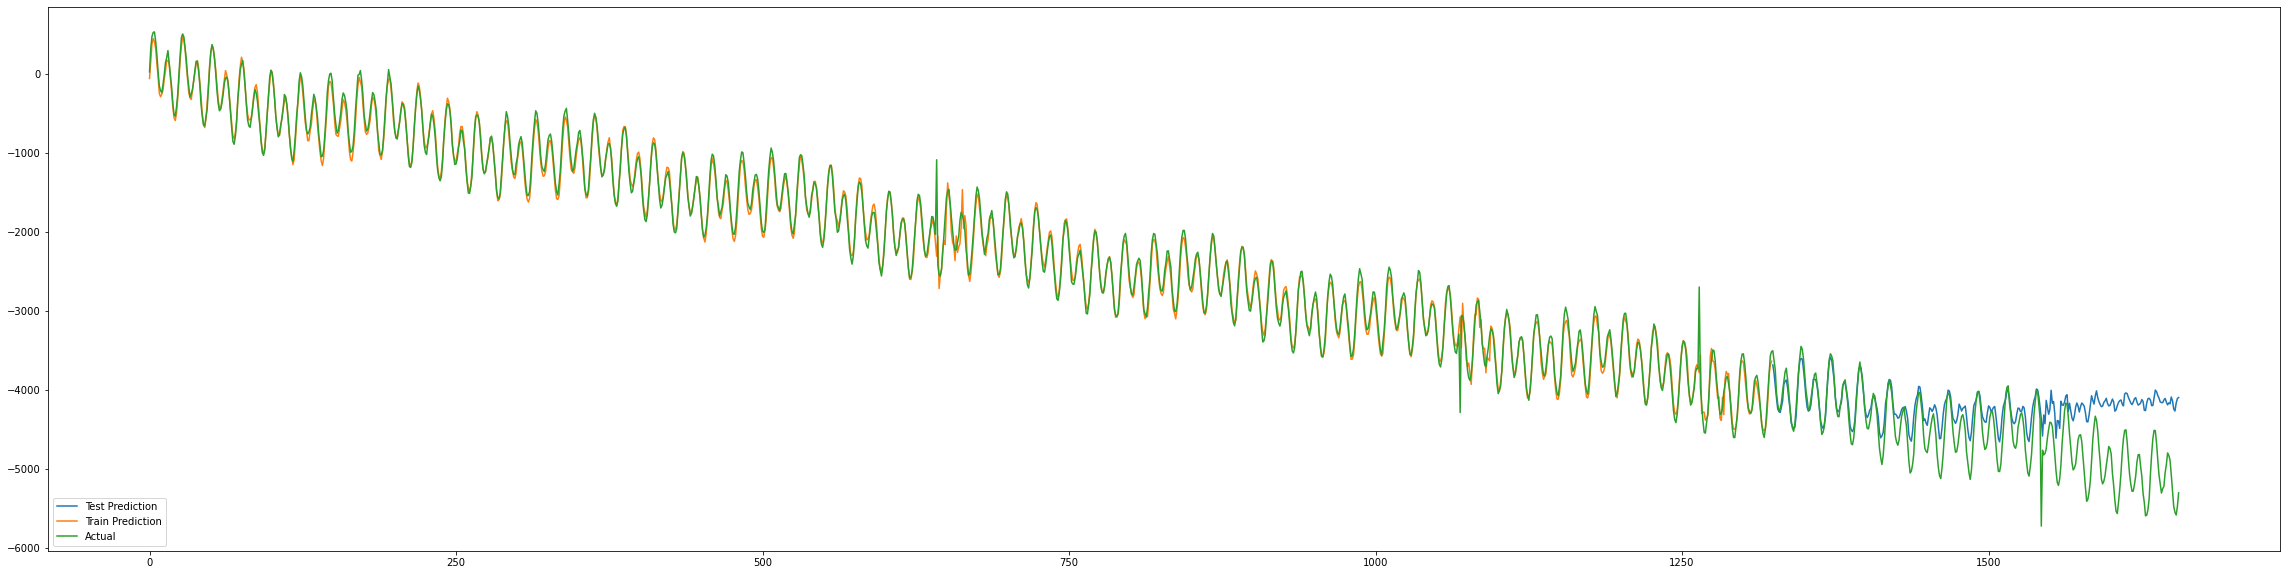

Deviation Min [1.05684352e-05], Max [0.19784214]
Deviation 99.5th pctile [0.06280302]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1652,    4]))
Confusion matrix 
[[1647    5]
 [   0    4]]
precision 0.44444, recall 1.00000, f1 0.61538
Time to train: 24649 ms
File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/A3Benchmark-TS73.csv
Shapes: Xtrain_full (1324, 24), Ytrain_full (1324, 1), Xtest (332, 24), Ytest (332, 1)
Shapes: Xtrain (1192, 24), Ytrain (1192, 1), Xvalid (132, 24), Yvalid (132, 1)
Epoch 1/25
25/25 [==============================] - 0s 15ms/step - loss: 0.0920 - val_loss: 0.0255
Epoch 2/25
25/25 [==============================] - 0s 8ms/step - loss: 0.0186 - val_loss: 0.0134
Epoch 3/25
25/25 [==============================] - 0s 8ms/step - loss: 0.0128 - val_loss: 0.0101
Epoch 4/25
25/25 [==============================] -

38/38 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 6/25
38/38 [==============================] - 0s 8ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 7/25
38/38 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 8/25
38/38 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 9/25
38/38 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 10/25
38/38 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 11/25
38/38 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0041
Epoch 12/25
38/38 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 13/25
38/38 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 14/25
38/38 [==============================] - 0s 8ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 15/25
38/38 [=======

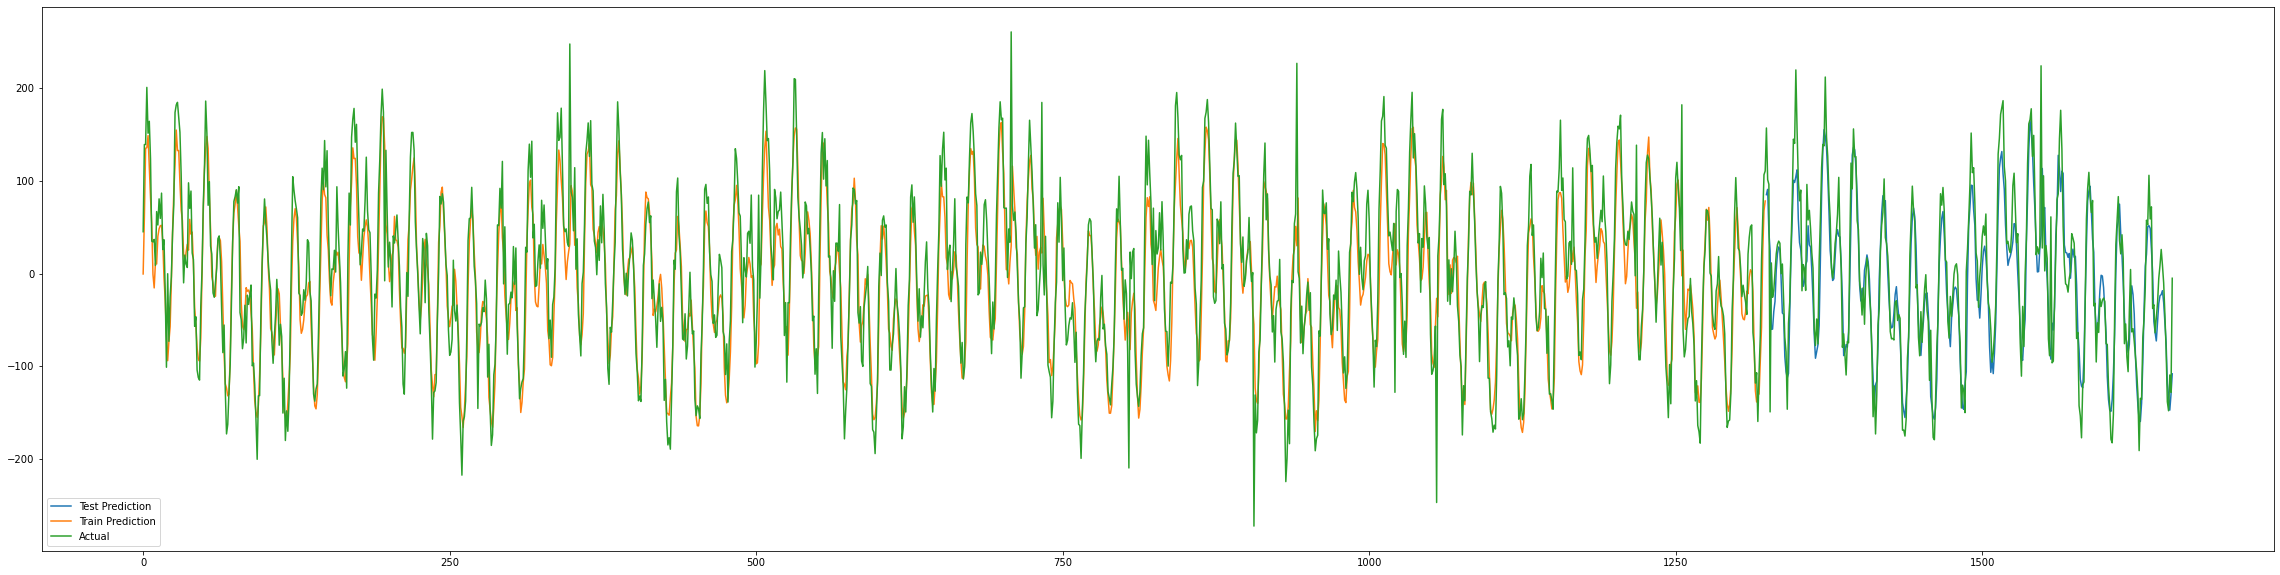

Deviation Min [7.15523298e-05], Max [0.43297917]
Deviation 99.5th pctile [0.32878296]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1641,   15]))
Confusion matrix 
[[1641    0]
 [   6    9]]
precision 1.00000, recall 0.60000, f1 0.75000
Time to train: 26376 ms
File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS20.csv
Shapes: Xtrain_full (1324, 24), Ytrain_full (1324, 1), Xtest (332, 24), Ytest (332, 1)
Shapes: Xtrain (1192, 24), Ytrain (1192, 1), Xvalid (132, 24), Yvalid (132, 1)
Epoch 1/25
25/25 [==============================] - 0s 16ms/step - loss: 0.0686 - val_loss: 0.0243
Epoch 2/25
25/25 [==============================] - 0s 9ms/step - loss: 0.0224 - val_loss: 0.0149
Epoch 3/25
25/25 [==============================] - 0s 10ms/step - loss: 0.0141 - val_loss: 0.0073
Epoch 4/25
25/25 [==============================] 

Epoch 10/25
38/38 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 11/25
38/38 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 12/25
38/38 [==============================] - 1s 16ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 13/25
38/38 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 14/25
38/38 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 15/25
38/38 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 16/25
38/38 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 17/25
38/38 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 18/25
38/38 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 19/25
38/38 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 20

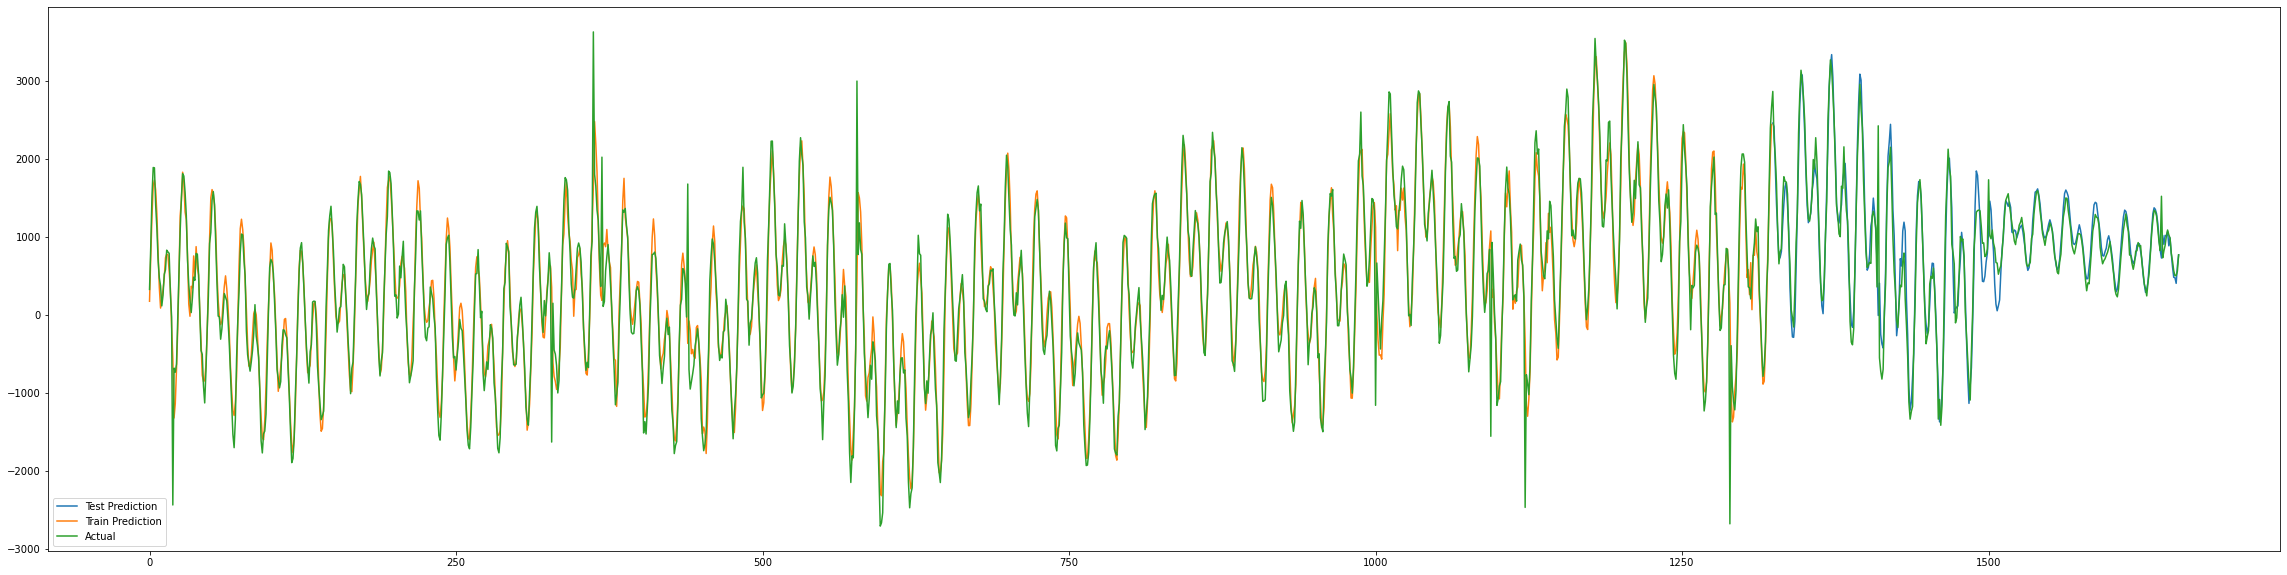

Deviation Min [4.85497812e-06], Max [0.44643277]
Deviation 99.5th pctile [0.30831137]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1643,   13]))
Confusion matrix 
[[1643    0]
 [   4    9]]
precision 1.00000, recall 0.69231, f1 0.81818
Time to train: 26605 ms
File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/A4Benchmark-TS68.csv
Shapes: Xtrain_full (1324, 24), Ytrain_full (1324, 1), Xtest (332, 24), Ytest (332, 1)
Shapes: Xtrain (1192, 24), Ytrain (1192, 1), Xvalid (132, 24), Yvalid (132, 1)
Epoch 1/25
25/25 [==============================] - 0s 15ms/step - loss: 0.0271 - val_loss: 0.0075
Epoch 2/25
25/25 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 3/25
25/25 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 4/25
25/25 [==============================] -

25/25 [==============================] - 0s 5ms/step - loss: 8.6493e-04 - val_loss: 9.7436e-04
Epoch 25/25
13/13 [==============================] - 0s 2ms/step - loss: 9.8012e-04
Epoch 1/25
38/38 [==============================] - 0s 13ms/step - loss: 0.0642 - val_loss: 0.0099
Epoch 2/25
38/38 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 3/25
38/38 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 4/25
38/38 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 5/25
38/38 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/25
38/38 [==============================] - 0s 7ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 7/25
38/38 [==============================] - 0s 9ms/step - loss: 9.9251e-04 - val_loss: 0.0013
Epoch 8/25
38/38 [==============================] - 0s 6ms/step - loss: 9.6953e-04 - val_loss: 0.0013
Epoch 9/25
38/38 [==========

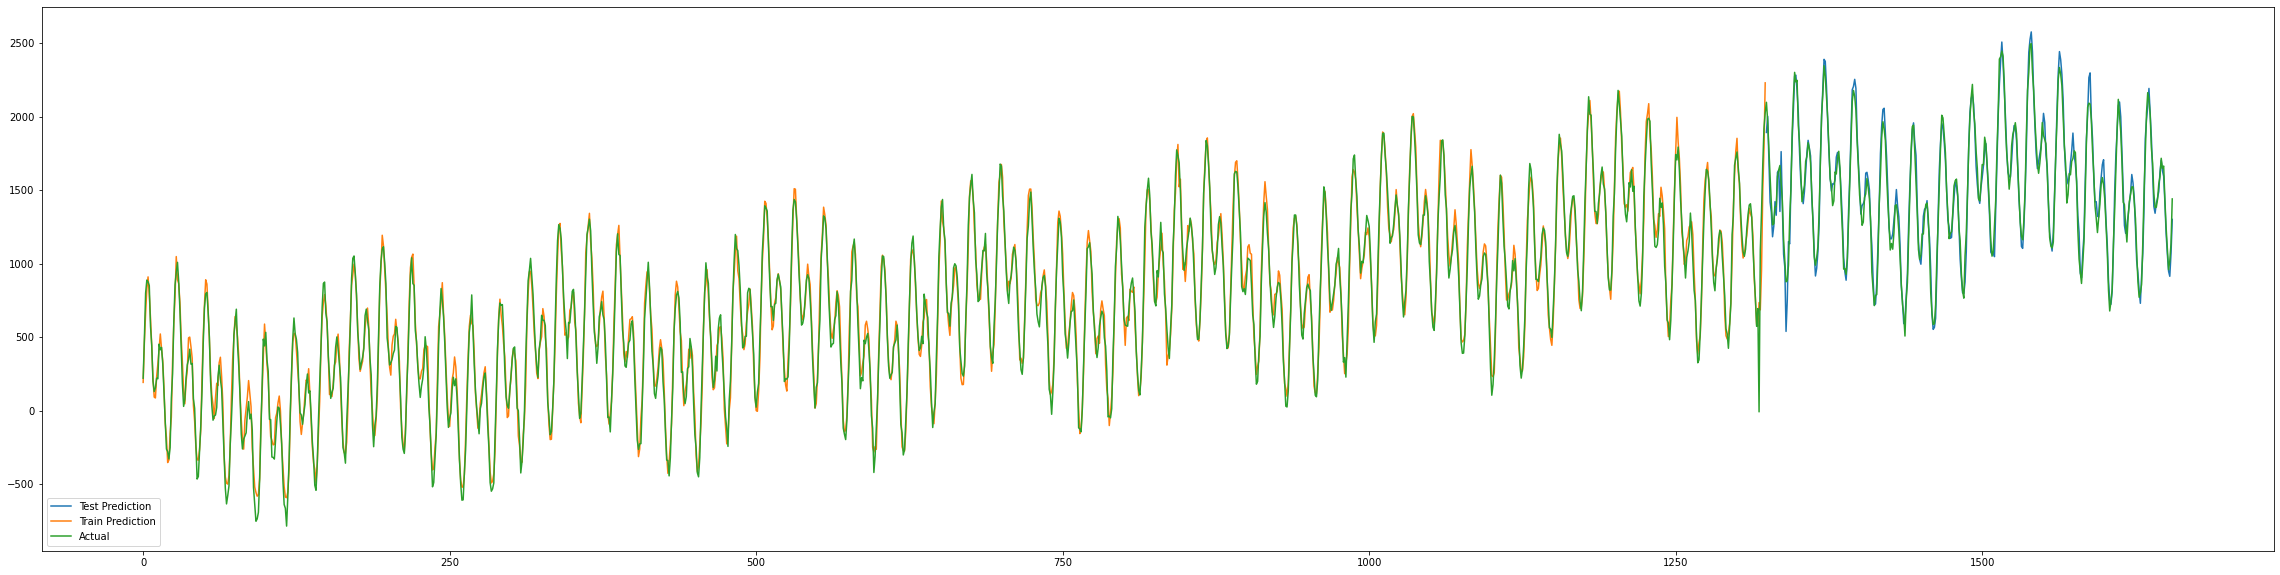

Deviation Min [2.63324123e-06], Max [0.22959168]
Deviation 99.5th pctile [0.07041936]
Deviation > 99.5th pctile is_anomaly labels in data (array([0, 1]), array([1647,    9]))
Actual is_anomaly labels in data (array([0, 1]), array([1655,    1]))
Confusion matrix 
[[1647    8]
 [   0    1]]
precision 0.11111, recall 1.00000, f1 0.20000
Time to train: 26500 ms
Total Time to proces all the selected files : 179172 ms


In [27]:
#files_to_process = 'ALL'
files_to_process = 2
directoryResultsMap = {}
start_millis = current_time_millis()
for folder, extension in DIRS_FILE_EXTENSIONS.items():
    timeVariantColumns = ['value']
    labelColumnNum = 2
    resultsMap = perform_training_on_benchmark_directory(folder, extension, timeVariantColumns, 
                                            labelColumnNum, param_distribs, files_to_process, plot_graph = 1)
    directoryResultsMap[folder] = resultsMap;
    #print_summary_for_benchmark_folder(resultsMap, folder)
end_millis = current_time_millis()
print("Total Time to proces all the selected files : {} ms".format(end_millis - start_millis))

## Print Statistics for each folder

In [28]:
#finally Print summary for each directory
for directory in directoryResultsMap.keys() :
    print_summary_for_benchmark_folder(directoryResultsMap[directory], directory)

A1Benchmark : Avg precision 0.41964 recall 0.51471 f1 0.44048 time to train 15582.00 ms
A2Benchmark : Avg precision 0.78571 recall 0.88889 f1 0.80114 time to train 17066.00 ms
A3Benchmark : Avg precision 0.72222 recall 0.80000 f1 0.68269 time to train 25512.50 ms
A4Benchmark : Avg precision 0.55556 recall 0.84615 f1 0.50909 time to train 26552.50 ms


**Decide if it would be better to calculate the deviations and classification metrics as a second pass and leave search to just find the best model.**. We see quite a wild variation in mean/max/qth pctile deviation across files.